# Mean Error Analysis

In [143]:
EXPORT_LATEX = False

%matplotlib inline 
# %matplotlib notebook would provide interactive plots

import glob
import csv
from os import path

import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib2tikz import save as _tikz_save

pd.set_option('display.precision', 3,
              'display.width', 300)

PATH_ROOT = '../matlab/mainczjs/evaluation/results/'
PATH_LATEX_PLOTS = '../latex/data/plots/'
PATH_LATEX_TABLES = '../latex/data/tables/'

NAME_FOLDER = "fixed-em-iterations-5"
NAME_EVALUATION = NAME_FOLDER
NAME_DATA_FILES = '*results.txt'
NAME_DATAFRAME = NAME_EVALUATION+'.pkl'

NAME_SCATTER_PLOT = NAME_EVALUATION+'-scatter.tex'
NAME_BOX_PLOT = NAME_EVALUATION+'-box.tex'
NAME_BAR_PLOT = NAME_EVALUATION+'-bar.tex'
NAME_SUMMARY_TABLE = NAME_EVALUATION+'-summary.tex'
NAME_PERFECT_MATCHES_PLOT = NAME_EVALUATION+'-perfect-matches-bar.tex'
PATH_SCATTER_PLOT = path.join(PATH_LATEX_PLOTS, NAME_SCATTER_PLOT)
PATH_BOX_PLOT = path.join(PATH_LATEX_PLOTS, NAME_BOX_PLOT)
PATH_BAR_PLOT = path.join(PATH_LATEX_PLOTS, NAME_BAR_PLOT)
PATH_LATEX_SUMMARY_TABLE = path.join(PATH_LATEX_TABLES, NAME_SUMMARY_TABLE)

lms_red = (204/255, 53/255, 56/255)

DICT_SUMMARY = {'x1':'count',  # sample size
                'em':np.mean,  # em-iterations
                'T60':np.mean,
                'SNR':np.mean,
                'err_mean':np.mean,
                'perfect_match':np.mean}

DEFAULT_LINE_PLOT_ARGS = {'kind':'line',
                          'marker':'o',
                          'color':[lms_red, "darkgray", "lightgray", "orange", "black"]}

def _get_trial_index(t):
    return ["t{}".format(i+1) for i in range(t)]

def _get_col_name(s,post):
    return sum([("x{}{},y{}{}".format(n,post,n,post)).split(',') for n in range(1,s+1)],[])

def _get_err_col_name(s):
    return ["err{}".format(n) for n in range(1,s+1)]

def get_col_names(s):
    return sum([_get_col_name(s,""), _get_col_name(s,"est"), _get_err_col_name(s)], []) 

def is_x1_correct(row):
    if abs(row["x1"]-row["x1est"]) > 0.001:
        if abs(row["y1"]-row["y1est"]) > 0.001:
            return 1
    return 0

def tikz_save(*args, **kwargs):
    """Wrapper for tikz_save function, that always suppresses additional info output"""
    kwargs['show_info'] = False 
    _tikz_save(*args, **kwargs)

def adjust_y_axis(step_size, digits=0, min=None):
    start, end = plt.axes().get_ylim()
    if min==None: min=start
    plt.yticks(np.arange(min, round(end+step_size, digits), step_size))

def scatter_plot(df, xaxis='n_sources', yaxis='err_mean'):
    x = df[xaxis].values
    y = df[yaxis].values
    means = df.groupby([xaxis]).mean()[yaxis]
    medians = df.groupby([xaxis]).median()[yaxis]
    plt.scatter(x, y, alpha=0.1, c="gray")
    plt.scatter(means.index.values, means.values, alpha=1.0, c=lms_red, marker="o", linewidth="4", label="mean")
    plt.scatter(medians.index.values, medians.values, alpha=1.0, c="black", marker="_", linewidth="2", label="median")
    # plt.xticks(n_sources_range)
    adjust_y_axis(step_size=0.5, digits=2, min=0)
    plt.grid(True, axis='y')
    plt.xlabel("number of sources")
    plt.ylabel("mean localisation error (m)")
    l = plt.legend()
    if EXPORT_LATEX:
        tikz_save(PATH_SCATTER_PLOT, show_info=False)

def style_boxplot(boxplots, fig=None, axes=None):
    if not type(boxplots)==type([]): boxplots=[boxplots]
    if not fig: fig = boxplots[0][0].ax.get_figure()
    if not axes: axes = [boxplots[0][0].ax]
    for bp in boxplots:
        for key in bp[0].lines.keys():
            for item in bp[0].lines[key]:
                if key=="fliers":
                    item.set_markerfacecolor("lightgray")
                    item.set_markeredgewidth(0)
                    item.set_markeredgecolor(lms_red)
                    item.set_markersize(7)
                if key=="medians":
                    item.set_color(lms_red)
                    item.set_linewidth(3)
                if key=="whiskers" or key=="caps":
                    item.set_color("gray")
                else:
                    item.set_color(lms_red)
    if axes:
        for ax in axes:
            ax.set_title("")
            ax.set_xlabel("number of sources")
            ax.set_ylabel("mean localisation error (m)")
            ax.grid(axis="x")
    if fig:
        fig.suptitle('')

def print_summary(df):
    print(df.description[1].upper()+":")
    summary = df.groupby('n_sources').agg(DICT_SUMMARY).rename(columns={'x1':'n', 'em':'em-iterations'})
    print(summary.transpose())
    for col in ['T60', 'em', 'SNR']:  # Print additional notes for these columns
        if df[col].min()!=df[col].max():
            col_values = df.pivot_table("x1", index=[col], columns=["n_sources"], aggfunc="count")
            if col_values.min().min()==col_values.max().max():
                n=col_values.min().min()
            else:
                if (col_values.min(axis=1).values-col_values.max(axis=1)).sum() == 0:
                    n = col_values.min(axis=1).values
                else:
                    print("WARN: Unbalanced n_sources for {}".format(col))
                    n="?"
            print("NOTE: Data contains range of {col} ({values}, n={n})".format(col=col, values=col_values.index.values, n=n))
    print()  # empty line at the end
            
def parse_parameters(fname):
    done=False
    s=0
    ret = {}
    while not done:
        i = fname.find("_", s)
        i2 = fname.find("_", i+1)
        s=i2
        if i < 0 or i2 < 0:
            done=True
            break
        else:
            fname_slice = fname[i+1:i2]
            name, value = fname_slice.split("=", 1)
            ret[name]=value
    return ret
        
def matlab2pandas(dirname=NAME_FOLDER, filename=NAME_DATA_FILES, save_to=None):
    files = glob.glob(path.join(PATH_ROOT,dirname,filename))
    dfs = []
    
    # read data
    for f in files:
        # look at filename
        fname = f.split(sep="/")[-1]
        params = parse_parameters(fname)
        n_sources = int(params["s"])
        # prepare DataFrame
        df = pd.DataFrame(list(csv.reader(open(f, 'r'), delimiter='\t')), dtype=float)
        df.drop(df.columns[[n_sources*4+n_sources]], axis=1, inplace=True) # drops empty column
        df.columns = get_col_names(n_sources)
        df.index = ["t{}".format(i+1) for i in range(len(df))]
        for key, value in params.items():
            df[key] = np.float(value)
        df["description"] = dirname
        dfs.append(df)
    df = pd.concat(dfs)
    
    # edit data
    df.rename(columns={'s':'n_sources'}, inplace=True)
    df['SNR'] = df['SNR'].apply(int)
    df['em'] = df['em'].apply(int)
    df['n_sources'] = df['n_sources'].apply(int)
    df["err_mean"]      = df.loc[:, "err1":_get_err_col_name(n_sources)[-1]].mean(axis=1)
    df["err_total"]     = df.loc[:, "err1":_get_err_col_name(n_sources)[-1]].sum(axis=1)
    df["perfect_match"] = df["err_total"]<=0.01
    
    print_summary(df)

    # export data
    if save_to: 
        df.to_pickle(save_to+".pkl")

    return df

T60:
n_sources            2        3        4        5        6        7
n              100.000  100.000  100.000  100.000  100.000  100.000
em-iterations   10.000   10.000   10.000   10.000   10.000   10.000
T60              0.300    0.300    0.300    0.300    0.300    0.300
SNR              0.000    0.000    0.000    0.000    0.000    0.000
err_mean         0.104    0.169    0.257    0.408    0.414    0.449
perfect_match    0.550    0.270    0.090    0.030    0.000    0.000



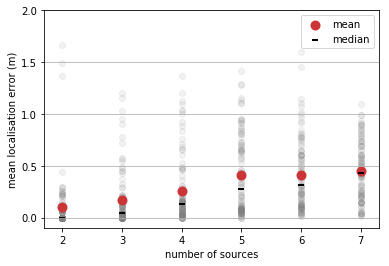

In [161]:
dft = df[df["em"]==10]
dft = dft[dft["T60"]==0.3]
print_summary(dft)
scatter_plot(dft)

## Base

BASE:
n_sources            2        3        4        5        6        7
n              100.000  100.000  100.000  100.000  100.000  100.000
em-iterations   10.000   10.000   10.000   10.000   10.000   10.000
T60              0.000    0.000    0.000    0.000    0.000    0.000
SNR              0.000    0.000    0.000    0.000    0.000    0.000
err_mean         0.035    0.023    0.137    0.157    0.255    0.329
perfect_match    0.930    0.860    0.620    0.440    0.270    0.190


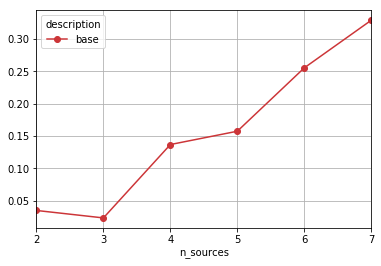

In [123]:
dfs = []
for desc in ['base']:
    dfs.append(matlab2pandas(dirname=desc, save_to=path.join(PATH_ROOT, desc)))
df = pd.concat(dfs)
dfp = df.pivot_table("err_mean", index="description", columns="n_sources", aggfunc='mean').transpose()
ax = dfp.plot(**DEFAULT_LINE_PLOT_ARGS, grid=True)

## Fixed EM-Iterations

FIXED-EM-ITERATIONS:
n_sources            2        3        4        5        6        7
n              150.000  150.000  150.000  150.000  150.000  150.000
em-iterations   11.667   11.667   11.667   11.667   11.667   11.667
T60              0.600    0.600    0.600    0.600    0.600    0.600
SNR              0.000    0.000    0.000    0.000    0.000    0.000
err_mean         0.195    0.260    0.385    0.469    0.515    0.633
perfect_match    0.313    0.113    0.013    0.007    0.000    0.000
NOTE: Data contains range of em ([ 5 10 20], n=50)



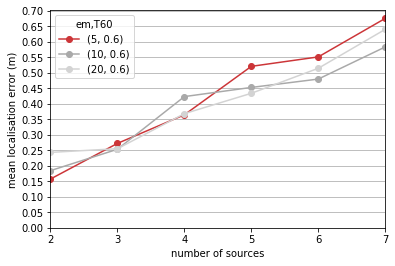

In [124]:
dfs = []
for desc in ['fixed-em-iterations']:
    dfs.append(matlab2pandas(dirname=desc, save_to=path.join(PATH_ROOT, desc)))
df = pd.concat(dfs, ignore_index=True)

dfp = df.pivot_table("err_mean", index=["em", "T60"], columns="n_sources", aggfunc='mean').transpose()
dfp.plot(**DEFAULT_LINE_PLOT_ARGS)
# Style plot
plt.xlabel("number of sources")
plt.ylabel("mean localisation error (m)")
plt.grid(axis="y")
adjust_y_axis(0.05, 2, 0)

## T60

T60:
n_sources            2        3       4        5        6        7
n              200.000  200.000  200.00  200.000  200.000  200.000
em-iterations   10.000   10.000   10.00   10.000   10.000   10.000
T60              0.600    0.600    0.60    0.600    0.600    0.600
SNR              0.000    0.000    0.00    0.000    0.000    0.000
err_mean         0.149    0.233    0.35    0.507    0.528    0.515
perfect_match    0.385    0.155    0.05    0.015    0.000    0.000
NOTE: Data contains range of T60 ([ 0.3  0.9], n=100)

FIXED-EM-ITERATIONS:
n_sources            2        3        4        5        6        7
n              150.000  150.000  150.000  150.000  150.000  150.000
em-iterations   11.667   11.667   11.667   11.667   11.667   11.667
T60              0.600    0.600    0.600    0.600    0.600    0.600
SNR              0.000    0.000    0.000    0.000    0.000    0.000
err_mean         0.195    0.260    0.385    0.469    0.515    0.633
perfect_match    0.313    0.113    0.013  

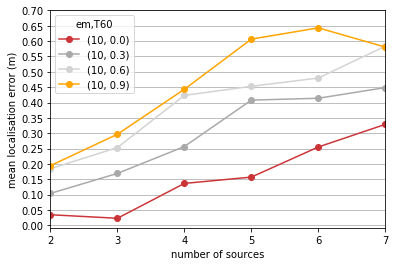

In [125]:
dfs = []
for desc in ['T60', 'fixed-em-iterations', 'base']:
    dfs.append(matlab2pandas(dirname=desc, save_to=path.join(PATH_ROOT, desc)))
df = pd.concat(dfs)

dfp = df[df["em"]==10].pivot_table("err_mean", index=["em", "T60"], columns="n_sources", aggfunc='mean').transpose()
dfp.plot(**DEFAULT_LINE_PLOT_ARGS)
# Style plot
plt.xlabel("number of sources")
plt.ylabel("mean localisation error (m)")
plt.grid(axis="y")
adjust_y_axis(0.05, 2, 0)

# Analyse DataFrame

### Plot

### Examine Outliers

In [ ]:
print(results[results["err_mean"]>=1.5])

# Compare DataFrames

## Mean error

In [ ]:
dfcp = dfc.pivot_table("err_mean", index="version", columns="n_sources", aggfunc='mean').transpose()
dfcp.plot(kind='line', marker='o', color=[lms_red, "darkgray", "lightgray", "orange", "black"])
# Style plot
plt.xlabel("number of sources")
plt.ylabel("mean localisation error (m)")
plt.grid(axis="y")
print(dfcp)

In [ ]:
# Box Plot
bp = dfc.boxplot('err_mean', by=["n_sources", "version"], return_type='both', figsize=(17,  12), showmeans=True, meanline=True)
style_boxplot(bp)

if EXPORT_LATEX:
    tikz_save(PATH_BOX_PLOT, show_info=False)

### Perfect matches

In [ ]:
dfcp = dfc.pivot_table("perfect_match", index="version", columns="n_sources", aggfunc='mean').transpose()
dfcp.plot(kind='line', marker='o', color=[lms_red, "darkgrey", "lightgray", "black", "darkgrey", "darkgrey"])
# Style plot
plt.xlabel("number of sources")
plt.ylabel("perfect matches")
plt.grid(axis="y")
# print(dfcp)

## Effect of em_iterations 

In [ ]:
files = glob.glob(path.join(PATH_ROOT, 'mean-err-n-sources-rnd-T60=0.6-em*-dataframe.pkl'))
from pprint import pprint
print("The following files match the criterion:")

dfs = []
for f in files:
    df = pd.read_pickle(f)
    fname = f.split(sep="/")[-1]
    print(fname)
    T60 = fname[fname.find("T60")+4:fname.find("T60")+7]
    df["T60"] = T60
    em_iterations = fname[fname.find("em=")+3:fname.find("em=")+5]
    if "-" in em_iterations: em_iterations = em_iterations[0]  # if em_iterations is a single digit
    df["em_iterations"] = em_iterations
    dfs.append(df)

dfc = pd.concat(dfs, ignore_index=True)
print("\nSUMMARY:")
print(dfc.groupby(by=["em_iterations", "n_sources", "T60"]).agg({'x1':'count', 'err_mean':np.mean, 'perfect_match':np.mean}).rename(columns={'x1':'sample size'}))

## Other

### Significance testing

In [ ]:
from scipy.stats import ttest_ind, describe, norm
from statsmodels.formula.api import ols

means = []
stddevs = []

fig, ax = plt.subplots(1,3, figsize=(17,  6))

# extract err_mean per n_sources
cat = {}
for n in n_sources_range:
    cat[str(n)] = results[results['n_sources']==n]['err_mean']

x = np.linspace(0,1.5,100)
print("DESCRIPTIVE ANALYSIS:")
for n, c in cat.items():
    dr = describe(c)
    means.append(dr.mean)
    stddevs.append(np.sqrt(dr.variance))
    y = norm.pdf(x, loc=dr.mean, scale=np.sqrt(dr.variance))
    plt.subplot(131)
    plt.plot(x, y, label=n)  # plot gaussian
    print("{} sources: n={:3}, min={:0.3f}, max={:0.3f}, mean={:0.3f}, variance={:0.3f}, std.dev={:0.3f}".format(
        n, dr.nobs, dr.minmax[0], dr.minmax[1], dr.mean, dr.variance, np.sqrt(dr.variance)))
plt.legend()

plt.subplot(132)
plt.boxplot(list(cat.values()), showmeans=True, meanline=True)

plt.subplot(133)
plt.boxplot(list(cat.values()), showmeans=True, meanline=True)
plt.ylim(-0.01, 0.31)
plt.yticks([0, 0.1, 0.2, 0.3])
# plt.plot([n_sources_range, n_sources_range], [means, stddevs], marker="o")  # plot mean
# plt.title("Means")
# plt.plot()
# plt.subplot(133)
# plt.plot(stddevs)  # plot variance

# This means that given p and t values from a two-tailed test, you would reject the null hypothesis 
# of a greater-than test when p/2 < alpha and t > 0, and of a less-than test when p/2 < alpha and t < 0.    

print("\nT-TEST FOR DIFFERENCE IN MEANS:")
for i1 in n_sources_range:
    for i2 in n_sources_range:
        if i1!=i2 and i2>i1 and i2<=i1+1:
            ttest = ttest_ind(cat[str(i2)], cat[str(i1)], equal_var=False)
            p_onesided = ttest.pvalue/2
            if p_onesided <= 0.01:sign="***"
            elif p_onesided <= 0.05: sign="**"
            elif p_onesided <= 0.10: sign="*"
            else: sign="(n.s.)"
            print("{}x{}: t={t.statistic:0.3f}, p={p:0.3f} {s:^6}".format(i1, i2, t=ttest, p=p_onesided, s=sign))

print("\nVISUALIZE MEANS AND VARIANCE OF DATA:")

## Guessing at random

In [ ]:
dfs = []
for desc in ['guessing-at-random', 'base']:
    dfs.append(matlab2pandas(dirname=desc, save_to=path.join(PATH_ROOT, desc)))
df = pd.concat(dfs)

dfp = df.pivot_table("err_mean", columns="n_sources", aggfunc='max').transpose()
dfp.plot(kind='line', marker='o', color=[lms_red, "darkgray", "lightgray", "orange", "black"])
# Style plot
plt.xlabel("number of sources")
plt.ylabel("mean localisation error (m)")
plt.grid(axis="y")
adjust_y_axis(0.2, 1, 0)

## T60